In [93]:
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime
import celerite
from celerite import terms
from scipy.optimize import minimize
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from datetime import timedelta, date
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from NEID_solar_functions import *
from GP_kernels import *

In [150]:
HD90043 = np.loadtxt('HD90043_LC.txt')
bjd  = HD90043[:,0]
flux = HD90043[:,1]
flux_err = HD90043[:,2]
t = bjd-min(bjd)

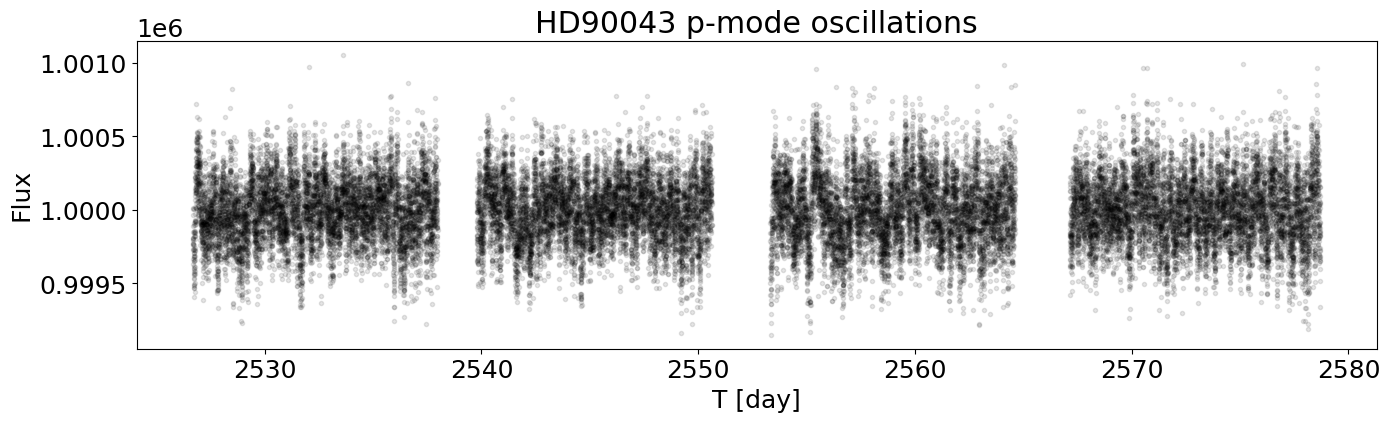

In [151]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 4))
plt.xlabel('T [day]')
plt.ylabel('Flux')
plt.title('HD90043 p-mode oscillations')
plt.plot(bjd, flux, 'k.', alpha=0.1)

In [96]:
(1/ 180e-6 )/60, 1/13.9e-6/60 # unit: minutes, 

(92.5925925925926, 1199.040767386091)

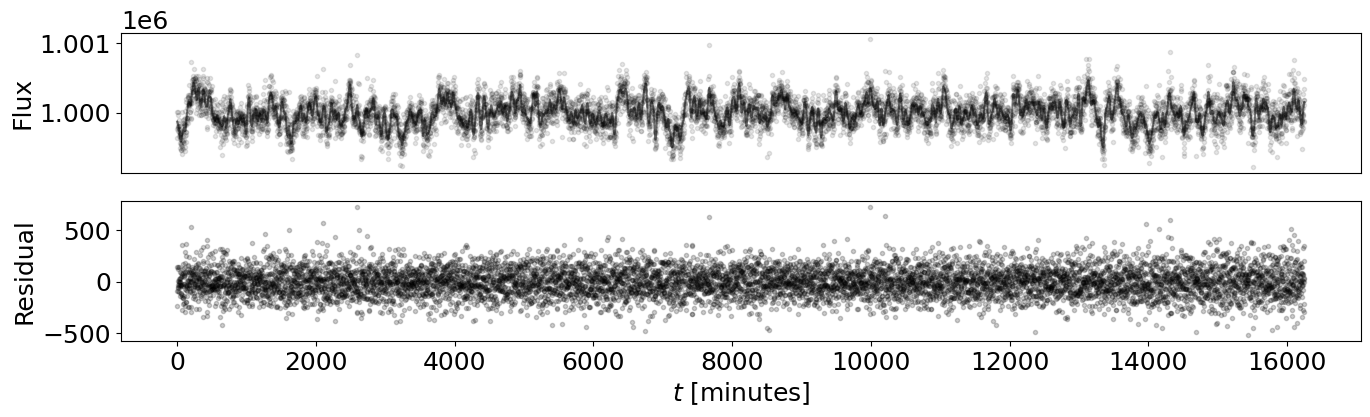

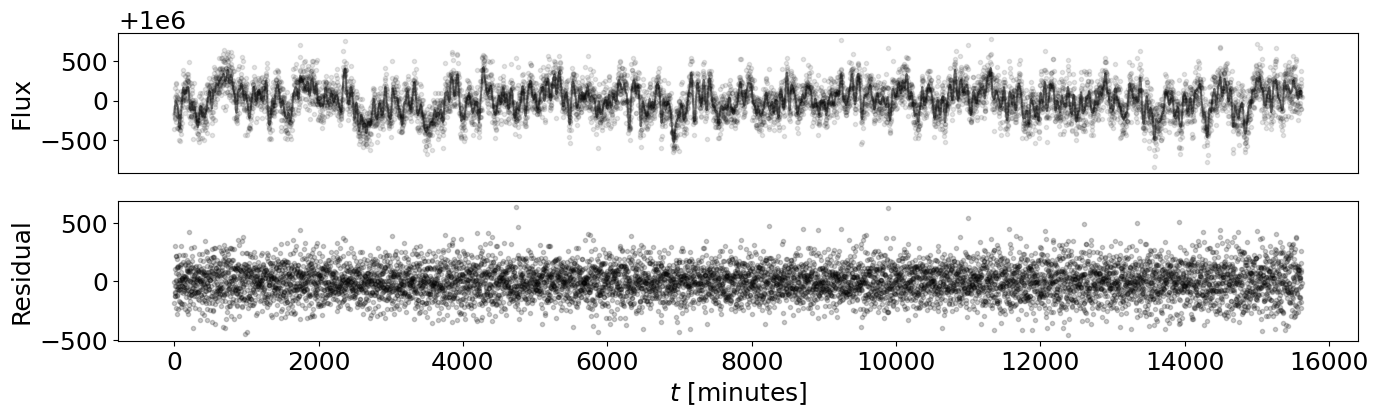

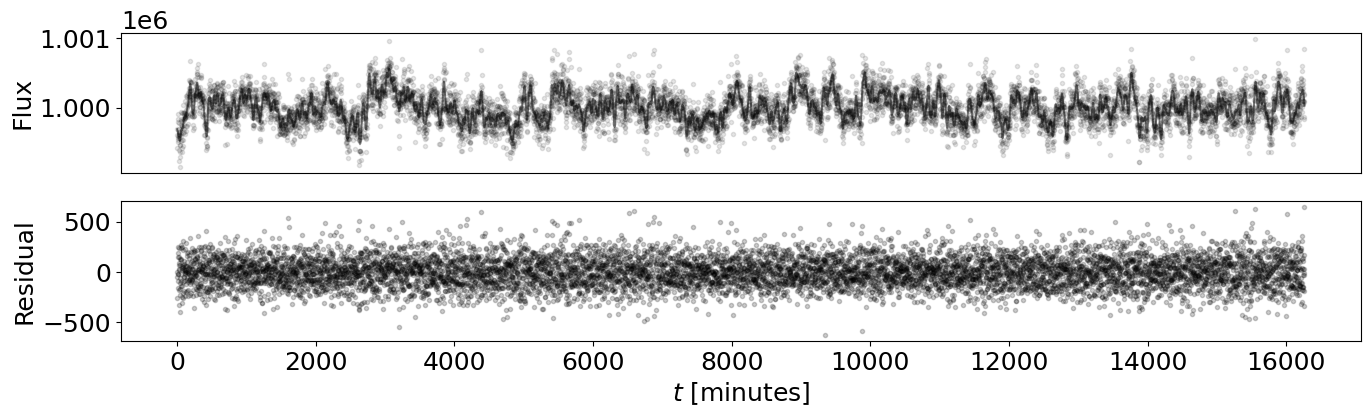

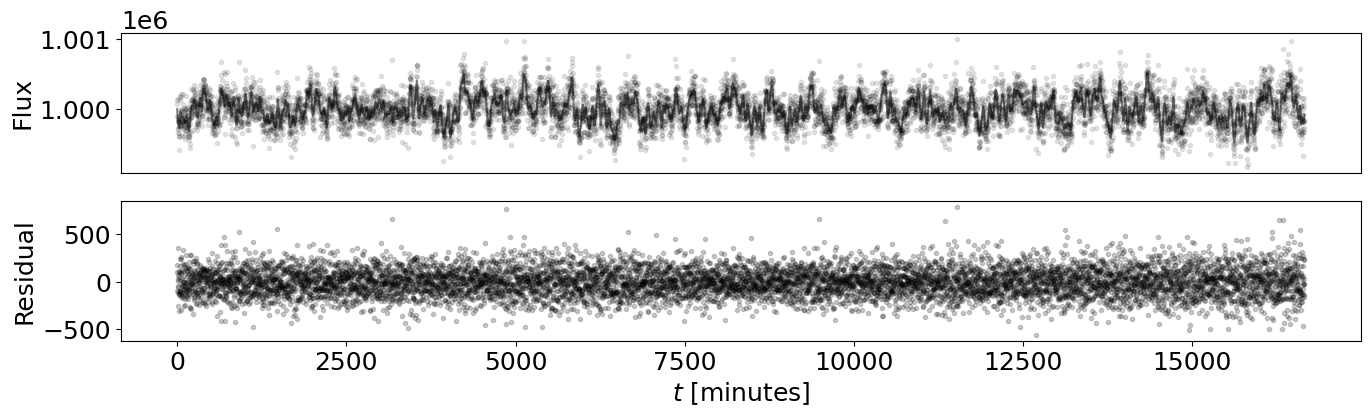

In [98]:
delta_t = 13.05

for i in range(4):

    bjd_min = min(bjd)
    idx = ((bjd>=bjd_min+i*delta_t) & (bjd<bjd_min+(i+1)*delta_t))
    t = (bjd[idx]-min(bjd[idx]))*24*60
    y = flux[idx]
    yerr = flux_err[idx]

    gp = GP_fit_p1(t, y, yerr, p=92.59)

    fig = plt.figure(figsize=(16, 4))
    fig.add_subplot(211)
    # plt.title(str(date)[:10])
    plt.plot(t, y, 'k.', alpha=0.1)
    x = np.linspace(min(t), max(t), 20000)
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)        
    plt.plot(x, pred_mean, color='k', alpha=0.5)
    plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='k', alpha=0.1,
                     edgecolor="none")
    plt.ylabel('Flux')
    plt.xticks([])

    fig.add_subplot(212)
    pred_mean_t, pred_var = gp.predict(y, t, return_var=True)
    plt.plot(t, y-pred_mean_t, 'k.', alpha=0.2)
    plt.xlabel('$t$ [minutes]')
    plt.ylabel('Residual')
    plt.show()

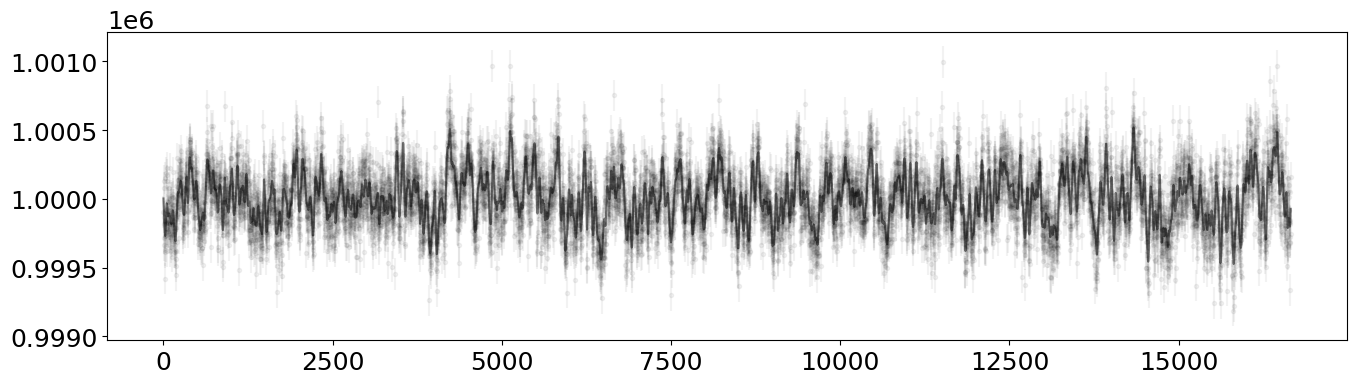

In [102]:
fig = plt.figure(figsize=(16, 4))
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.05)
# plt.plot(t, y, 'k.', alpha=0.1)
plt.plot(x, pred_mean, color='k', alpha=0.5)
# plt.xlim([2000, 6000])

### 1 - no correction 

In [152]:
import statsmodels.api as sm

Cov_XYs = []

for i in range(4):

    bjd_min = min(bjd)
    idx = ((bjd>=bjd_min+i*delta_t) & (bjd<bjd_min+(i+1)*delta_t))
    t = (bjd[idx]-min(bjd[idx]))*24*60
    y = flux[idx]
    yerr = flux_err[idx]
    print(max(t) - min(t))
    
    gp = GP_fit_p1(t, y, yerr, p=92.59)
    Delta_t = np.arange(0, max(t), step=1)
    cov_XY = []
    pred_mean, pred_var = gp.predict(y, Delta_t, return_var=True)
    ACF = sm.tsa.acovf(pred_mean, fft=True)/(1-Delta_t/max(Delta_t))

    if len(Cov_XYs) == 0:
        Cov_XYs = ACF[Delta_t<=10000]
    else:
        Cov_XYs = np.vstack((Cov_XYs, ACF[Delta_t<=10000]))

16249.543148369266


/tmp/ipykernel_3406391/2076972395.py:18: RuntimeWarning: divide by zero encountered in divide
  ACF = sm.tsa.acovf(pred_mean, fft=True)/(1-Delta_t/max(Delta_t))


15619.549234529404
16261.586136614278
16655.500552082158


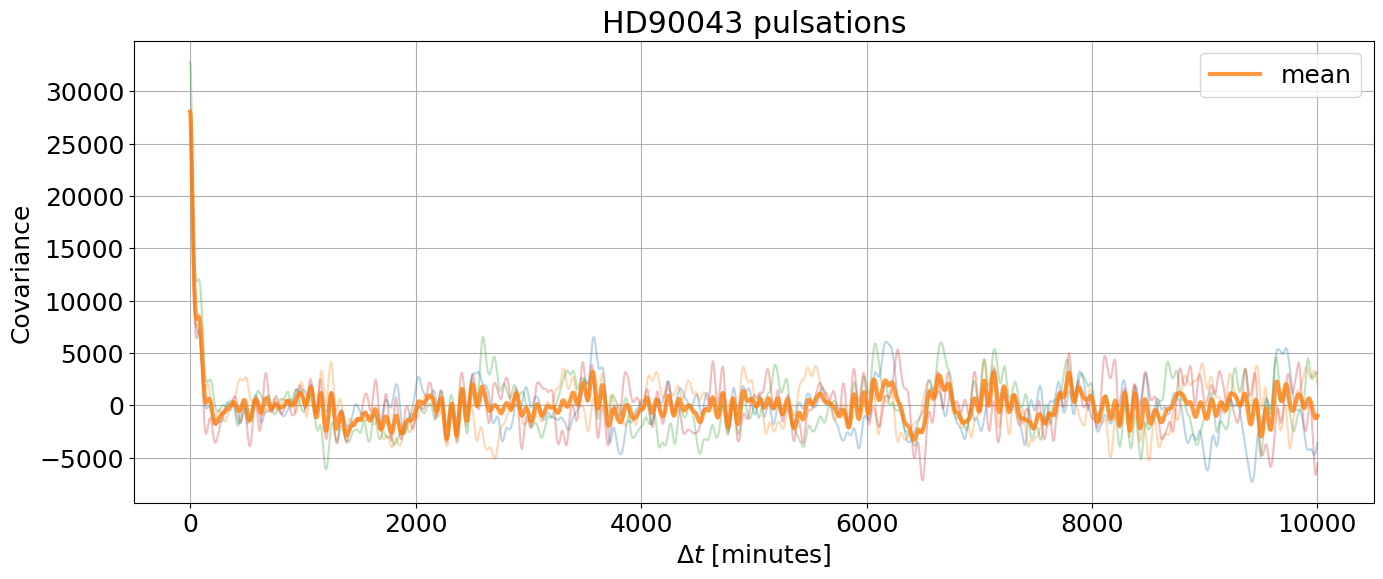

In [153]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
# plt.plot(Delta_t, ACF, 'k', alpha=0.5)
plt.plot(Delta_t[Delta_t<=10000], Cov_XYs.T, alpha=0.3)
plt.plot(Delta_t[Delta_t<=10000], np.mean(Cov_XYs, axis=0), lw=3, color='tab:orange', alpha=0.8, label='mean')
# plt.plot(Delta_t[Delta_t<=600], np.median(Cov_XYs, axis=0), lw=2, alpha=0.9, label='median')
plt.title('HD90043 pulsations')
# plt.xlim([-1,2000])
# plt.ylim([-0.7,0.9])
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance')
plt.legend()
plt.grid()
# plt.savefig('./Figure/SONG_cov.png')
plt.show()

### 2 - smooth variations


In [158]:
def long_short_divide(x, y, yerr, r):
	'''
	x 		= bjd_daily
	y 		= shift_function[i,:]
	yerr 	= err_shift_spectrum[i,:]
	'''

	import george
	from george import kernels

	kernel 	= 10*np.var(y) * kernels.Matern52Kernel(r**2)
	gp 		= george.GP(kernel)
	gp.compute(x, yerr)

	y_pred, _ 	= gp.predict(y, x, return_var=True)
	long_term 	= y_pred
	short_term 	= y - y_pred

	return gp, short_term, long_term

y = y-np.mean(y)
_, short_variation, long_variation = long_short_divide(x=t, y=y, yerr=yerr, r=250)



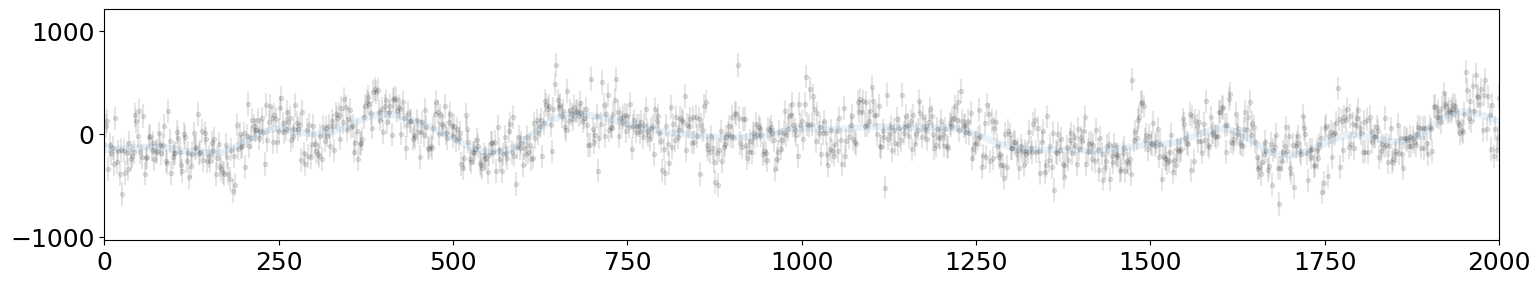

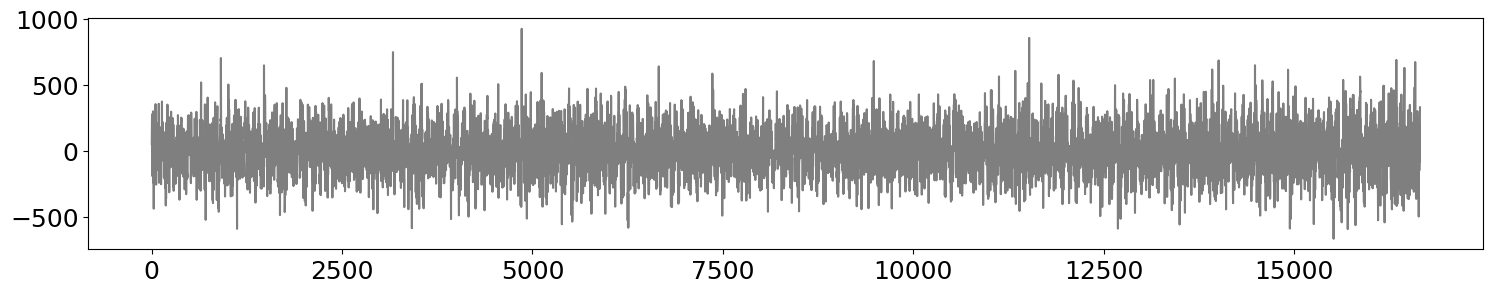

In [159]:
fig = plt.figure(figsize=(18, 3))
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
plt.plot(t, long_variation, lw=5, alpha=0.1)
plt.xlim([0,2000])
plt.show()

fig = plt.figure(figsize=(18, 3))
# plt.errorbar(t, short_variation, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
plt.plot(t, short_variation, 'k-', alpha=0.5)
# plt.xlim([0,2000])
plt.show()

In [160]:
import statsmodels.api as sm

Cov_XYs = []

for i in range(4):

    bjd_min = min(bjd)
    idx = ((bjd>=bjd_min+i*delta_t) & (bjd<bjd_min+(i+1)*delta_t))
    t = (bjd[idx]-min(bjd[idx]))*24*60
    y = flux[idx]
    yerr = flux_err[idx]
    print(max(t) - min(t))
    
    y = y-np.mean(y)
    _, short_variation, long_variation = long_short_divide(x=t, y=y, yerr=yerr, r=250)

    gp = GP_fit_p1(t, short_variation, yerr, p=92.59)
    Delta_t = np.arange(0, max(t), step=1)
    cov_XY = []
    pred_mean, pred_var = gp.predict(y, Delta_t, return_var=True)
    ACF = sm.tsa.acovf(pred_mean, fft=True)/(1-Delta_t/max(Delta_t))

    if len(Cov_XYs) == 0:
        Cov_XYs = ACF[Delta_t<=10000]
    else:
        Cov_XYs = np.vstack((Cov_XYs, ACF[Delta_t<=10000]))

16249.543148369266


/tmp/ipykernel_3406391/667186496.py:21: RuntimeWarning: divide by zero encountered in divide
  ACF = sm.tsa.acovf(pred_mean, fft=True)/(1-Delta_t/max(Delta_t))


15619.549234529404
16261.586136614278
16655.500552082158


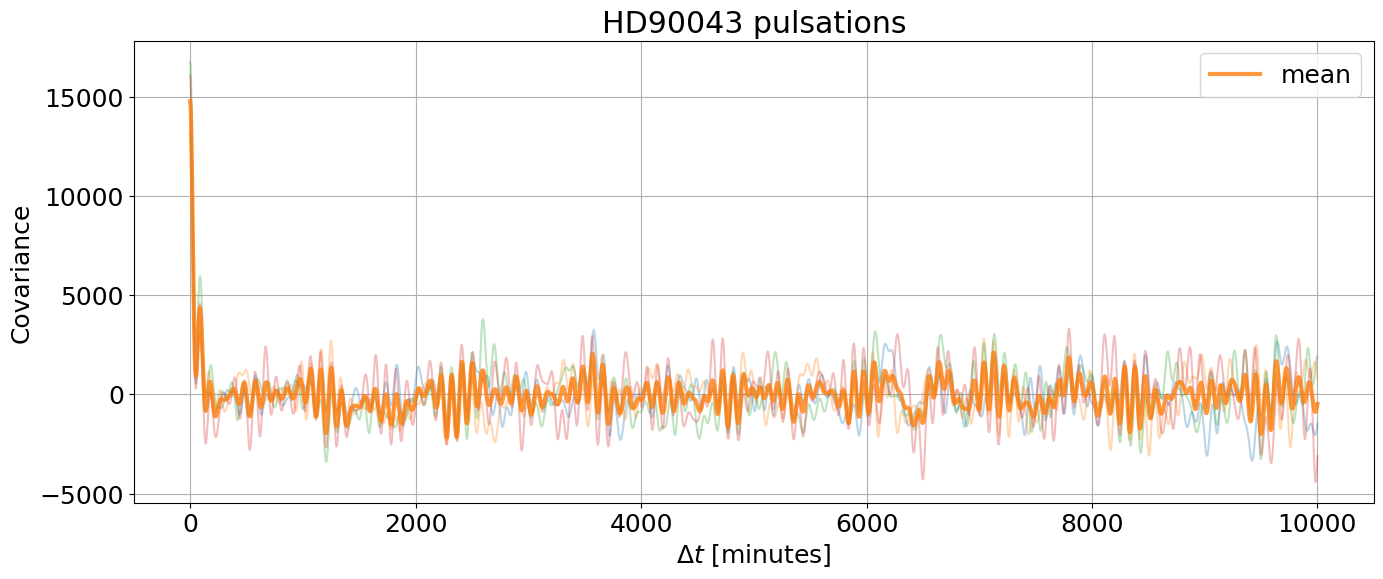

In [161]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
# plt.plot(Delta_t, ACF, 'k', alpha=0.5)
plt.plot(Delta_t[Delta_t<=10000], Cov_XYs.T, alpha=0.3)
plt.plot(Delta_t[Delta_t<=10000], np.mean(Cov_XYs, axis=0), lw=3, color='tab:orange', alpha=0.8, label='mean')
# plt.plot(Delta_t[Delta_t<=600], np.median(Cov_XYs, axis=0), lw=2, alpha=0.9, label='median')
plt.title('HD90043 pulsations')
# plt.xlim([-1,2000])
# plt.ylim([-0.7,0.9])
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance')
plt.legend()
plt.grid()
# plt.savefig('./Figure/SONG_cov.png')
plt.show()

### 3 -- split within a day

In [162]:
import statsmodels.api as sm

Cov_XYs = []

for i in range(4):

    bjd_min = min(bjd)
    idx = ((bjd>=bjd_min+i*delta_t) & (bjd<bjd_min+(i+1)*delta_t))
    t1 = (bjd[idx]-min(bjd[idx]))*24*60
    y1 = flux[idx]
    yerr1 = flux_err[idx]

    y1 = y1-np.mean(y1)
    _, short_variation, long_variation = long_short_divide(x=t1, y=y1, yerr=yerr1, r=250)
    y1 = short_variation
        
    for k in range(2):
        idx = (t1>(k*7500)) & (t1<((k+1)*7500))
        t = t1[idx]
        y = y1[idx]
        yerr = yerr1[idx]
        

        gp = GP_fit_p1(t, y, yerr, p=92.59)
        Delta_t = np.arange(0, max(t), step=1)
        cov_XY = []
        pred_mean, pred_var = gp.predict(y, Delta_t, return_var=True)
        ACF = sm.tsa.acovf(pred_mean, fft=True)/(1-Delta_t/max(Delta_t))

        if len(Cov_XYs) == 0:
            Cov_XYs = ACF[Delta_t<=7000]
        else:
            Cov_XYs = np.vstack((Cov_XYs, ACF[Delta_t<=7000]))

/tmp/ipykernel_3406391/2184926794.py:28: RuntimeWarning: divide by zero encountered in divide
  ACF = sm.tsa.acovf(pred_mean, fft=True)/(1-Delta_t/max(Delta_t))


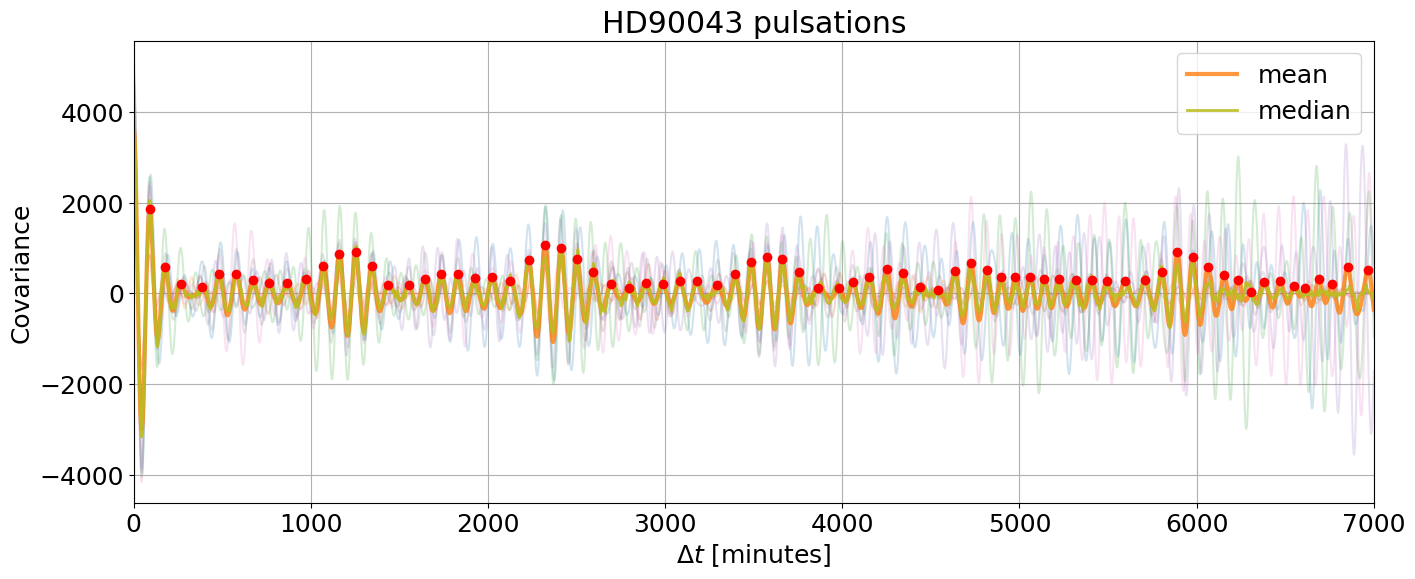

In [167]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(np.mean(Cov_XYs, axis=0), height=20)


plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
# plt.plot(Delta_t, ACF, 'k', alpha=0.5)
plt.plot(Delta_t[Delta_t<=7000], Cov_XYs.T, alpha=0.2)
plt.plot(Delta_t[Delta_t<=7000], np.mean(Cov_XYs, axis=0), lw=3, color='tab:orange', alpha=0.8, label='mean')
plt.plot(Delta_t[Delta_t<=7000], np.median(Cov_XYs, axis=0), lw=2, alpha=0.9, label='median')
plt.plot(Delta_t[Delta_t<=7000][peaks], np.mean(Cov_XYs, axis=0)[peaks], "ro")
plt.title('HD90043 pulsations')
# plt.xlim([-1,2000])
# plt.ylim([-0.7,0.9])
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance')
plt.legend()
plt.grid()
plt.xlim([0,7000])
# plt.savefig('./Figure/SONG_cov.png')
plt.show()

In [180]:
each_peak = Delta_t[Delta_t<=7000][peaks]
each_peak, len(each_peak), np.mean(each_peak/(np.arange(75)+1)), 1/(6967/75*60)*1e6, 1/(96.25*60)*1e6

(array([  90.,  177.,  265.,  387.,  482.,  578.,  673.,  764.,  866.,
         974., 1071., 1161., 1252., 1343., 1436., 1552., 1643., 1736.,
        1830., 1925., 2023., 2124., 2230., 2322., 2412., 2502., 2595.,
        2694., 2796., 2890., 2985., 3082., 3180., 3292., 3395., 3487.,
        3574., 3662., 3753., 3864., 3980., 4060., 4153., 4251., 4343.,
        4437., 4539., 4636., 4727., 4815., 4896., 4977., 5060., 5140.,
        5222., 5317., 5410., 5493., 5598., 5708., 5803., 5891., 5977.,
        6064., 6156., 6236., 6309., 6382., 6472., 6551., 6611., 6690.,
        6764., 6852., 6967.]),
 75,
 95.49862927127151,
 179.4172527630257,
 173.16017316017317)

In [129]:
1250/13

96.15384615384616

In [146]:
import statsmodels.api as sm

Cov_XYs = []

for i in range(4):

    bjd_min = min(bjd)
    idx = ((bjd>=bjd_min+i*delta_t) & (bjd<bjd_min+(i+1)*delta_t))
    t1 = (bjd[idx]-min(bjd[idx]))*24*60
    y1 = flux[idx]
    yerr1 = flux_err[idx]
        
    for k in range(2):
        idx = (t1>(k*7500)) & (t1<((k+1)*7500))
        t = t1[idx]
        y = y1[idx]
        yerr = yerr1[idx]
        

        gp = GP_fit_p1(t, y, yerr, p=92.59)
        Delta_t = np.arange(0, max(t), step=1)
        cov_XY = []
        pred_mean, pred_var = gp.predict(y, Delta_t, return_var=True)
        ACF = sm.tsa.acovf(pred_mean, fft=True)/(1-Delta_t/max(Delta_t))

        if len(Cov_XYs) == 0:
            Cov_XYs = ACF[Delta_t<=7000]
        else:
            Cov_XYs = np.vstack((Cov_XYs, ACF[Delta_t<=7000]))

/tmp/ipykernel_3406391/1733478675.py:24: RuntimeWarning: divide by zero encountered in divide
  ACF = sm.tsa.acovf(pred_mean, fft=True)/(1-Delta_t/max(Delta_t))


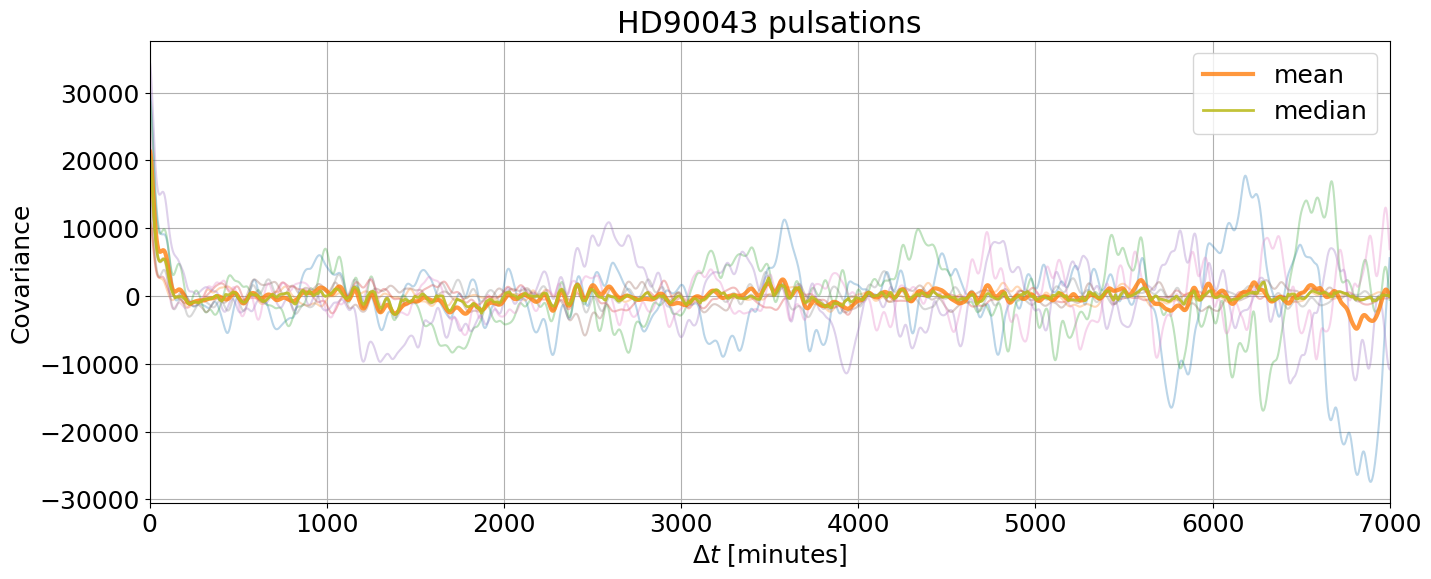

In [147]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
# plt.plot(Delta_t, ACF, 'k', alpha=0.5)
plt.plot(Delta_t[Delta_t<=7000], Cov_XYs.T, alpha=0.3)
plt.plot(Delta_t[Delta_t<=7000], np.mean(Cov_XYs, axis=0), lw=3, color='tab:orange', alpha=0.8, label='mean')
plt.plot(Delta_t[Delta_t<=7000], np.median(Cov_XYs, axis=0), lw=2, alpha=0.9, label='median')
plt.title('HD90043 pulsations')
# plt.xlim([-1,2000])
# plt.ylim([-0.7,0.9])
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance')
plt.legend()
plt.grid()
plt.xlim([0,7000])
# plt.savefig('./Figure/SONG_cov.png')
plt.show()